In [8]:
%pip install -r ../requirements.txt
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload



[notice] A new release of pip available: 22.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
# Import necessary libraries
import sys
import os
import shutil
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath(os.path.join(os.pardir, 'src')))

# Import project-specific internal modules
from preprocessor import DataPreprocessor
from plots import PlotGenerator
from src import config
from config import RUN_CONFIGURATION, EMOTION_STATES, NLP_CONFIG, SENTIMENT_MODEL_EXPORT_PATH_RAW, \
    SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, EMOTION_VARIATIONS_PATH, NEGATION_PATTERNS_PATH, \
    HYPERPARAMETERS, RANDOM_STATE, PREDICTION_MODEL_EXPORT_PATH, is_step_enabled
from src.sentiment_analysis import SentimentAnalysisModel
from src.emotion_postprocessor import EmotionPostProcessor
from src.clinical_notes_prediction import ClinicalNotesNoShowPredictor

# Create an instance of the preprocessing and plotting classes
preprocessor = DataPreprocessor(config)
plotter = PlotGenerator(style='whitegrid', palette='viridis', figsize=(10, 6))

sns.set(style='whitegrid')
warnings.filterwarnings("ignore")

In [10]:
if is_step_enabled('dataload'):
    df = preprocessor.load_data(config.DATASET_PATH)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

'shape:'

(110527, 17)

'columns:'

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,PatientNotes,PatientSentiment,NoShowReason
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No,Patient with poorly controlled hypertension (s...,Patient is worried about long-term effects of ...,"Positive experiences with clinic staff, such a..."
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No,Elderly patient. Discussed fall prevention str...,Confusion about insurance coverage and billing...,"A clear understanding of their health status, ..."
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No,Patient with hypertension is following a low-s...,Anxiety and confusion about diabetes care cont...,"A clear understanding of their health status, ..."
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,Child accompanied by parent/guardian. Reviewed...,Patient is worried about memory loss and manag...,The patient is committed to managing chronic c...
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No,The patient is managing type 2 diabetes with M...,Fear of medication side effects and doubts abo...,The patient prioritizes following medical advi...


,PatientId,AppointmentID,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


# Pre Processing

In [11]:
if is_step_enabled('data_preprocess'):
    df = preprocessor.preprocess_data(df)
    display("shape:", df.shape)
    display("columns:", df.columns)
    display(df.head())
    display(df.describe())

[preprocessing] Starting preprocessing...
Initial shape of the dataset: (110527, 17)
Initial columns in the dataset: Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'PatientNotes', 'PatientSentiment', 'NoShowReason'],
      dtype='object')
Dropping unnecessary columns...
Remaining columns: Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason'],
      dtype='object')
Converting date columns to datetime...
Handling missing values...
Adding emotional state columns...
Handling missing values...
Adding emotional state columns...
Emotional state columns added: ['anxiety', 'stress', 'confusion', 'hopeful', 'fear']
Final shape of the datas

'shape:'

(110527, 21)

'columns:'

Index(['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood',
       'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap',
       'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment',
       'NoShowReason', 'WaitDays', 'anxiety', 'stress', 'confusion', 'hopeful',
       'fear'],
      dtype='object')

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,...,No-show,PatientNotes,PatientSentiment,NoShowReason,WaitDays,anxiety,stress,confusion,hopeful,fear
0,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62.0,JARDIM DA PENHA,0,1,0,0,0,...,0,Patient with poorly controlled hypertension (s...,Patient is worried about long-term effects of ...,"Positive experiences with clinic staff, such a...",-1,0,1,1,0,1
1,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,0,0,0,0,...,0,Elderly patient. Discussed fall prevention str...,Confusion about insurance coverage and billing...,"A clear understanding of their health status, ...",-1,0,1,1,0,0
2,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62.0,MATA DA PRAIA,0,0,0,0,0,...,0,Patient with hypertension is following a low-s...,Anxiety and confusion about diabetes care cont...,"A clear understanding of their health status, ...",-1,1,0,1,0,0
3,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8.0,PONTAL DE CAMBURI,0,0,0,0,0,...,0,Child accompanied by parent/guardian. Reviewed...,Patient is worried about memory loss and manag...,The patient is committed to managing chronic c...,-1,0,0,0,0,0
4,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56.0,JARDIM DA PENHA,0,1,1,0,0,...,0,The patient is managing type 2 diabetes with M...,Fear of medication side effects and doubts abo...,The patient prioritizes following medical advi...,-1,0,0,0,0,1


,Gender,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,WaitDays,anxiety,stress,confusion,hopeful,fear
count,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,0.350023,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,0.201933,9.183702,0.491979,0.603273,0.532594,0.106336,0.426412
std,0.476979,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,0.401444,15.254996,0.499938,0.489221,0.498939,0.308269,0.494557
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000
75%,1.000000,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,14.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,1.000000,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,178.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Exploratory Data Analysis (EDA)

In this section, we perform exploratory data analysis on the patient appointments dataset to understand the data, visualize key features, and derive insights.

## Visualizations

Visualize the distribution of key features and their relationships.

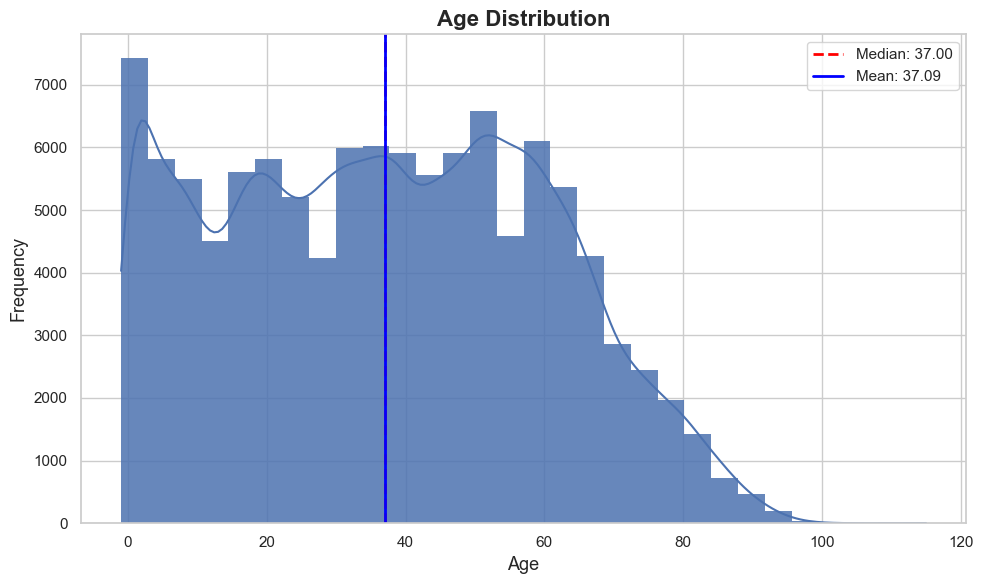

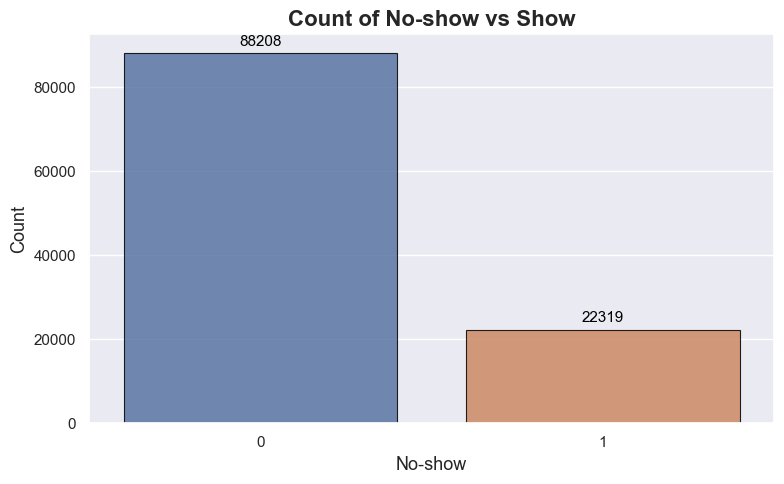

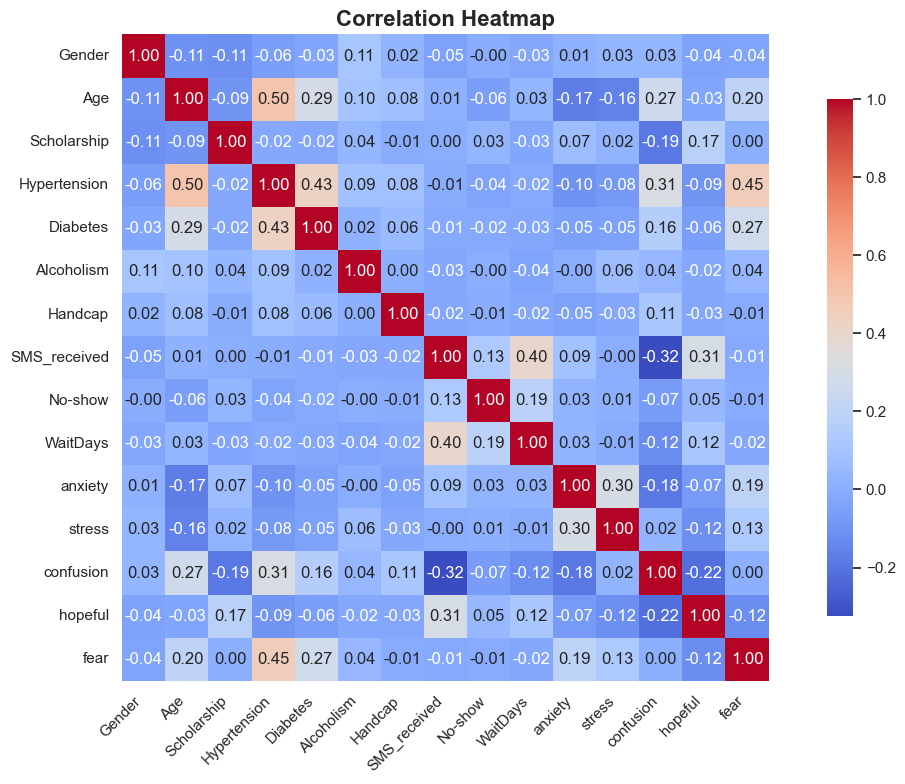

In [12]:
if is_step_enabled('eda'):
    # Distribution of Age - Using class-based approach
    plotter.plot_histplot(
        data=df,
        column='Age',
        bins=30,
        kde=True,
        title='Age Distribution',
        xlabel='Age',
        ylabel='Frequency',
        figsize=(10, 6)
    )

    # Countplot of No-show vs Show
    plotter.plot_countplot(
        data=df,
        column='No-show',
        title='Count of No-show vs Show',
        xlabel='No-show',
        ylabel='Count',
        figsize=(8, 5)
    )

    # Correlation heatmap 
    numeric_df = df.select_dtypes(include=[np.number])
    correlation_matrix = numeric_df.corr()
    plotter.plot_heatmap(
        data=correlation_matrix,
        title='Correlation Heatmap',
        fmt='.2f',
        cmap='coolwarm',
        square=True,
        figsize=(12, 8)
    )

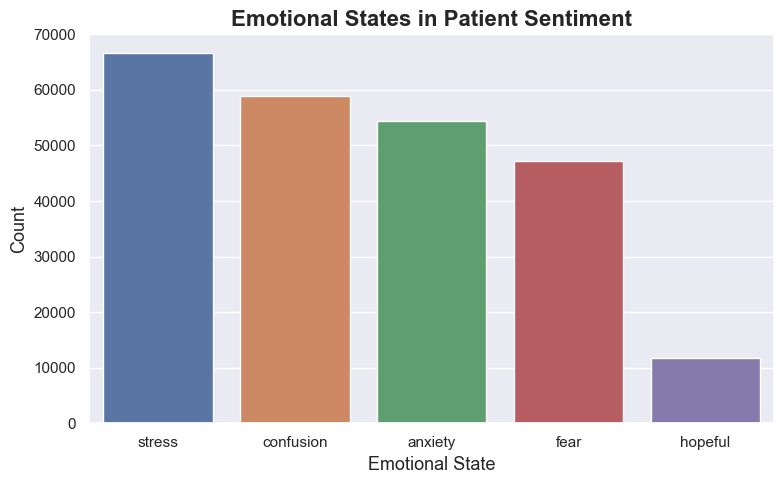

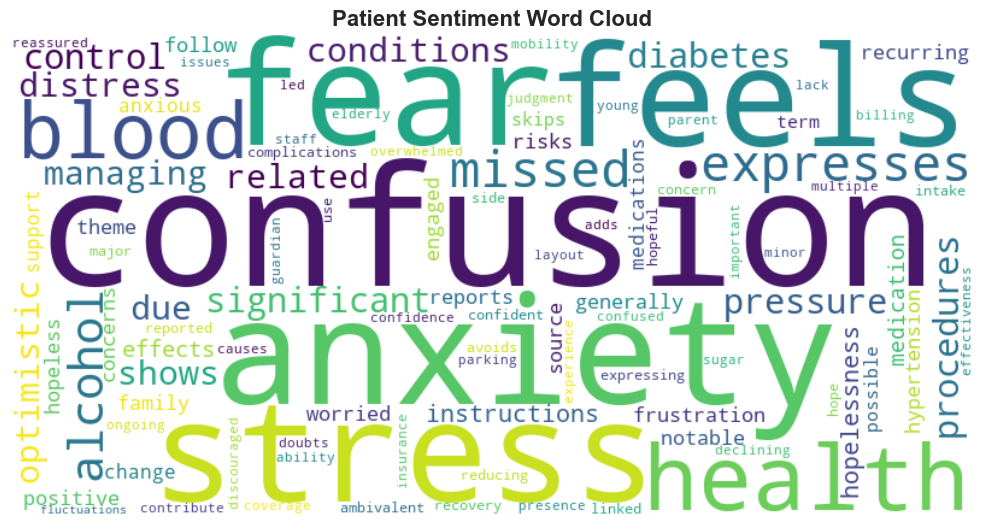

Total unique words after filtering: 161
Top 10 most frequent words: {'confusion': 77779, 'anxiety': 62099, 'fear': 57339, 'stress': 55610, 'feels': 54774, 'health': 50047, 'blood': 35628, 'expresses': 34563, 'missed': 33931, 'alcohol': 29663}


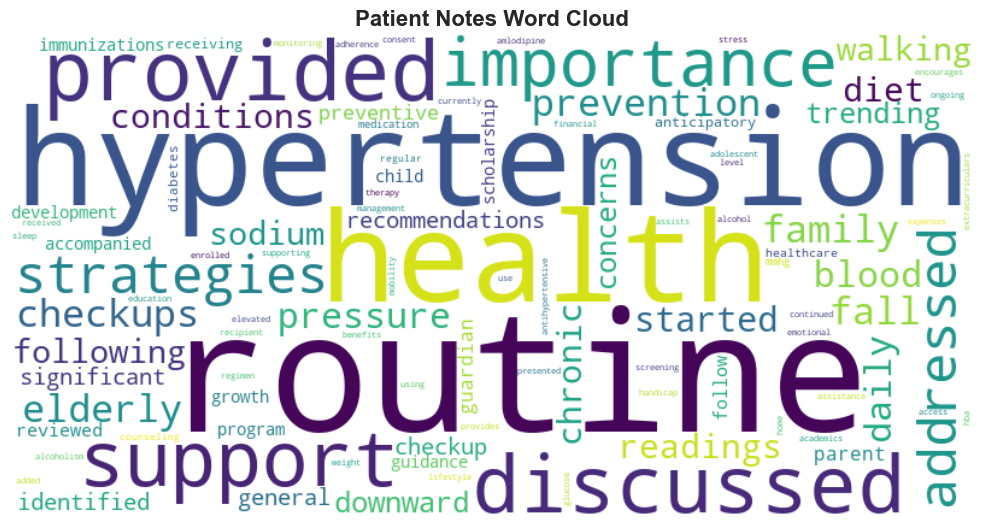

Total unique words after filtering: 480
Top 10 most frequent words: {'routine': 75106, 'hypertension': 69899, 'health': 62876, 'provided': 61365, 'discussed': 56894, 'support': 54154, 'importance': 45468, 'strategies': 43443, 'addressed': 43435, 'prevention': 43424}


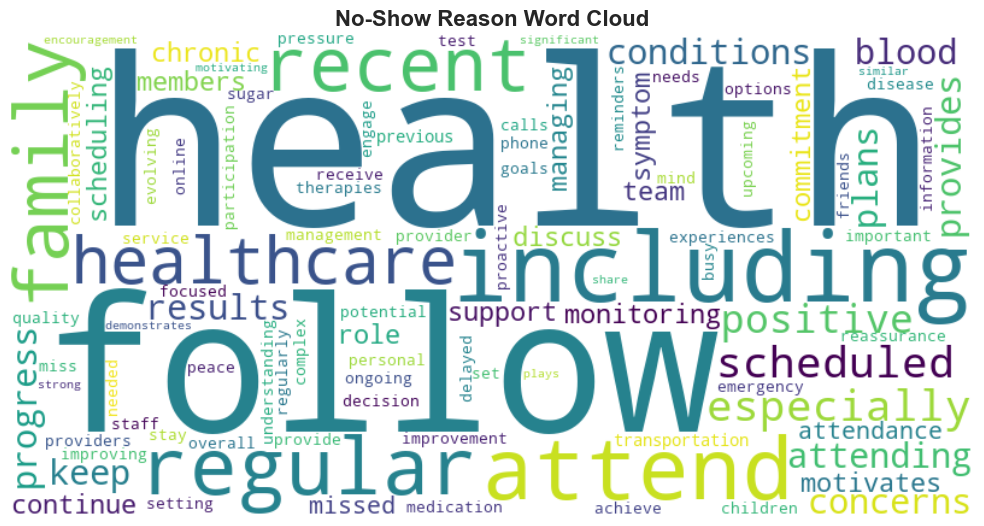

Total unique words after filtering: 477
Top 10 most frequent words: {'health': 35477, 'follow': 21074, 'including': 19948, 'attend': 15422, 'regular': 15302, 'family': 13660, 'recent': 13186, 'healthcare': 11945, 'especially': 11621, 'scheduled': 11592}


In [13]:
if is_step_enabled('eda'):
    # Plot emotional states as a bar plot - Using class method
    plotter.plot_emotional_states_bar(df)

    # Plot word clouds for PatientSentiment, PatientNotes, and NoShowReason
    plotter.plot_text_wordcloud_custom_stopwords(df['PatientSentiment'], title='Patient Sentiment Word Cloud')
    plotter.plot_text_wordcloud_custom_stopwords(df['PatientNotes'], title='Patient Notes Word Cloud')
    plotter.plot_text_wordcloud_custom_stopwords(df['NoShowReason'], title='No-Show Reason Word Cloud')

# Supervised Learning for Patient Show/No Show Prediction

Implement supervised learning algorithms to predict patient show/no-show.

# Unsupervised Learning

Apply unsupervised learning techniques to cluster patients.

## Unsupervised Learning Conclusion

K-Means and GMM clustering provided insights into patient groupings.

# NLP Analysis on Patient Appointments

Perform NLP analysis on patient notes and sentiments.

1. Patient Sentiment Analysis - TinyBert
1. Patient Notes Analysis -  ClinicalBERT
1. No Show Reason Analysis - DistillBERT

# Patient Sentiment Analysis (TinyBERT)

This section analyzes patient sentiments using a TinyBERT-based transformer model, with emotion and negation handling. The approach is optimized for CPU and reuses project configuration and CSVs.

In [14]:
if is_step_enabled('nlp_sentiment_analysis'):
    # First, let's check what columns are available in our DataFrame
    print("Available columns:", df.columns.tolist())
    print("DataFrame shape:", df.shape)
    
    # Check if emotion columns exist, if not create them from PatientSentiment text
    emotion_columns_exist = all(col in df.columns for col in EMOTION_STATES)
    print(f"Emotion columns exist: {emotion_columns_exist}")
    
    if not emotion_columns_exist:
        print("Creating emotion columns from PatientSentiment text...")
        # Create emotion columns by checking if emotion words appear in PatientSentiment
        for emotion in EMOTION_STATES:
            df[emotion] = df['PatientSentiment'].str.lower().str.contains(emotion, na=False).astype(int)
        print("Emotion columns created successfully!")
    
    # Now create our sentiment analysis DataFrame
    features = ['PatientSentiment', 'No-show'] + EMOTION_STATES
    available_features = [col for col in features if col in df.columns]
    print(f"Using features: {available_features}")
    
    sa_df = df[available_features].dropna()
    print("Sentiment Analysis DataFrame shape:", sa_df.shape)
    print("Sentiment Analysis DataFrame columns:", sa_df.columns.tolist())
    print("Sample emotion distribution:")
    for emotion in EMOTION_STATES:
        if emotion in sa_df.columns:
            print(f"  {emotion}: {sa_df[emotion].sum()} positive cases out of {len(sa_df)}")

    # Initialize the improved sentiment analysis model
    print("\nInitializing improved sentiment analysis model...")
    sa_model = SentimentAnalysisModel(sa_df, emotional_states=EMOTION_STATES, device=NLP_CONFIG['device'])

    # Train the model with improved anti-overfitting techniques
    print("Training model with improved regularization...")
    sa_model.train(epochs=5, patience=3)  # More epochs but better patience for proper training

    # Evaluate the model with threshold tuning
    print("Evaluating model with optimized thresholds...")
    predictions, actual_labels = sa_model.evaluate()

    # Get metrics
    sentiment_analysis_metrics = sa_model.report(predictions, actual_labels)
    print("Training completed successfully!")

Available columns: ['Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show', 'PatientNotes', 'PatientSentiment', 'NoShowReason', 'WaitDays', 'anxiety', 'stress', 'confusion', 'hopeful', 'fear']
DataFrame shape: (110527, 21)
Emotion columns exist: True
Using features: ['PatientSentiment', 'No-show', 'anxiety', 'stress', 'confusion', 'hopeful', 'fear']
Sentiment Analysis DataFrame shape: (110527, 7)
Sentiment Analysis DataFrame columns: ['PatientSentiment', 'No-show', 'anxiety', 'stress', 'confusion', 'hopeful', 'fear']
Sample emotion distribution:
  anxiety: 54377 positive cases out of 110527
  stress: 66678 positive cases out of 110527
  confusion: 58866 positive cases out of 110527
  hopeful: 11753 positive cases out of 110527
  fear: 47130 positive cases out of 110527

Initializing improved sentiment analysis model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training model with improved regularization...
Epoch 1/5


Validating: 100%|██████████| 415/415 [00:15<00:00, 26.68it/s]


Epoch 1: Train Loss: 0.5791, Val Loss: 0.3714
Epoch 2/5


Validating: 100%|██████████| 415/415 [00:16<00:00, 24.73it/s]


Epoch 2: Train Loss: 0.3559, Val Loss: 0.2477
Epoch 3/5


Validating: 100%|██████████| 415/415 [00:15<00:00, 26.33it/s]


Epoch 3: Train Loss: 0.3032, Val Loss: 0.2058
Epoch 4/5


Validating: 100%|██████████| 415/415 [00:14<00:00, 27.73it/s]


Epoch 4: Train Loss: 0.2857, Val Loss: 0.1888
Epoch 5/5


Validating: 100%|██████████| 415/415 [00:15<00:00, 26.59it/s]


Epoch 5: Train Loss: 0.2799, Val Loss: 0.1838
Training completed in 1476.90 seconds
Evaluating model with optimized thresholds...


Evaluating: 100%|██████████| 691/691 [00:24<00:00, 28.62it/s]


Optimal threshold for anxiety: 0.50, F1: 0.963
Optimal threshold for stress: 0.35, F1: 0.960
Optimal threshold for confusion: 0.45, F1: 0.955
Optimal threshold for hopeful: 0.20, F1: 0.930
Optimal threshold for fear: 0.50, F1: 0.956
Training completed successfully!


Model Accuracy by Emotion:
  anxiety: 0.9644
  stress: 0.9528
  confusion: 0.9537
  hopeful: 0.9862
  fear: 0.9639

Overall Accuracy: 0.9642

Classification Reports:

Anxiety:
  Not Present: {'precision': 0.9346208510994064, 'recall': 0.9994635672776039, 'f1-score': 0.965955240646332, 'support': 11185.0}
  Present: {'precision': 0.9994085756530311, 'recall': 0.9283948356377622, 'f1-score': 0.962593752966866, 'support': 10921.0}
  macro avg: {'precision': 0.9670147133762188, 'recall': 0.963929201457683, 'f1-score': 0.964274496806599, 'support': 22106.0}
  weighted avg: {'precision': 0.9666278510021539, 'recall': 0.9643535691667421, 'f1-score': 0.9642945690210969, 'support': 22106.0}

Stress:
  Not Present: {'precision': 0.8959669079627715, 'recall': 0.9957476152166418, 'f1-score': 0.9432257362146862, 'support': 8701.0}
  Present: {'precision': 0.997024766806047, 'recall': 0.9249533756061171, 'f1-score': 0.9596377849154445, 'support': 13405.0}
  macro avg: {'precision': 0.946495837384409

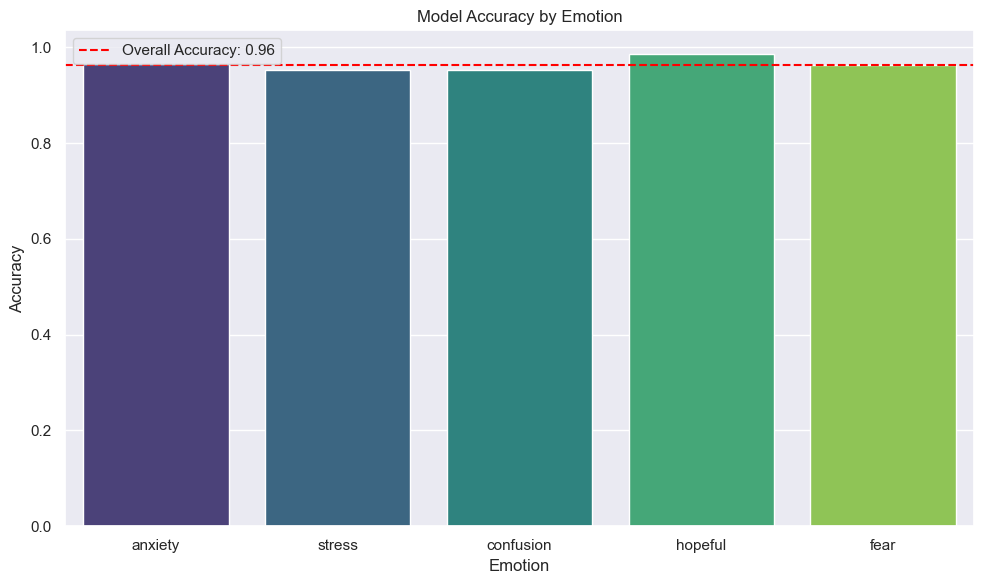

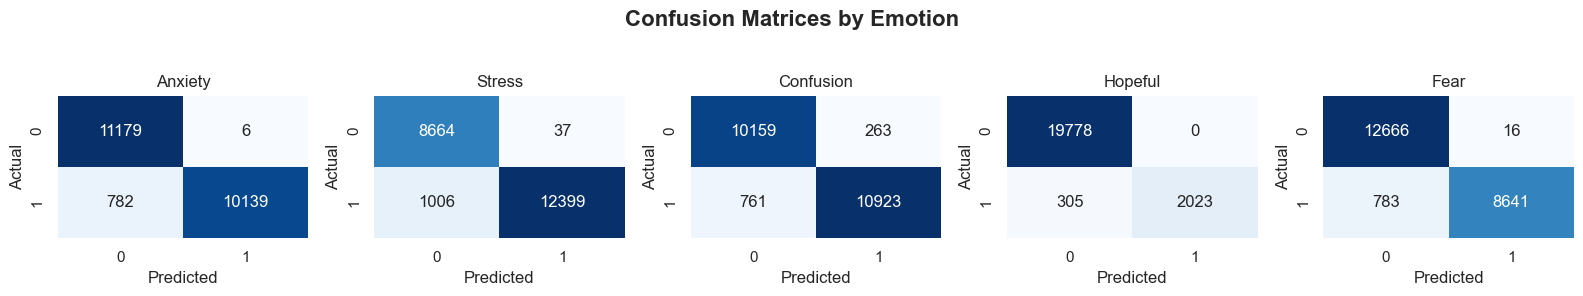

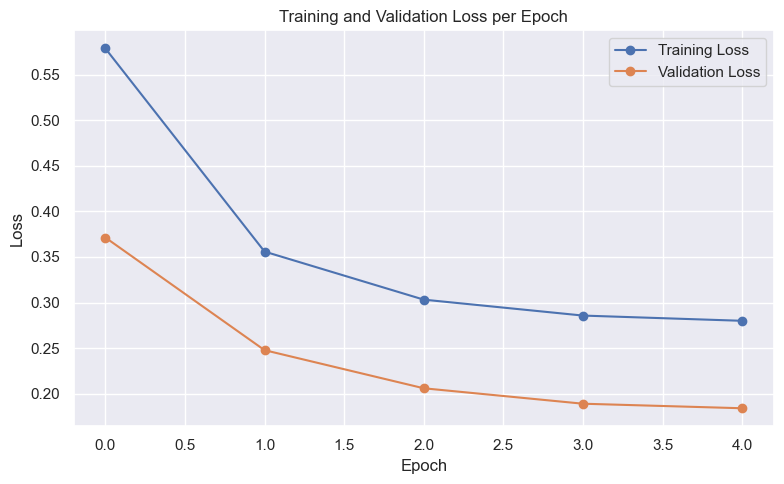

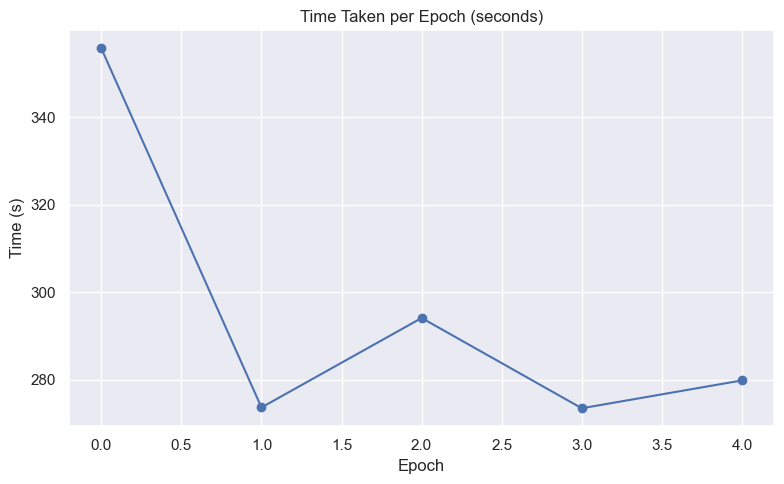

In [15]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Print metrics in a readable format
    plotter.print_sentiment_metrics(sentiment_analysis_metrics)

    # Plot accuracy by emotion with overall accuracy line
    plotter.plot_accuracy_by_emotion(sentiment_analysis_metrics)

    # Plot confusion matrices for each emotion
    plotter.plot_confusion_matrices(actual_labels, predictions, sa_model.emotional_states)

    # Plot training and validation loss
    sa_stats = sa_model.get_training_stats()
    plotter.plot_training_validation_loss(sa_stats['training_losses'], sa_stats['validation_losses'])

    # Plot time taken per epoch
    plotter.plot_epoch_times(sa_stats['epoch_times'])



--- Hyperparameter Configuration 1/2 ---
Learning Rate: 5e-05
Batch Size: 16
Max Epochs: 2
Early Stopping Patience: 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating Epoch 1: 100%|██████████| 415/415 [00:33<00:00, 12.35it/s]


Epoch 1: Train Loss: 0.3609, Val Loss: 0.0007


Validating Epoch 2: 100%|██████████| 415/415 [00:21<00:00, 19.21it/s]


Epoch 2: Train Loss: 0.2702, Val Loss: 0.0007
Early stopping counter: 1/1
Early stopping triggered after 2 epochs


Evaluating: 100%|██████████| 691/691 [00:35<00:00, 19.37it/s]


Overall Accuracy: 0.9584
Training Time: 1088.28 seconds

--- Hyperparameter Configuration 2/2 ---
Learning Rate: 0.0001
Batch Size: 16
Max Epochs: 2
Early Stopping Patience: 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validating Epoch 1: 100%|██████████| 415/415 [00:29<00:00, 14.22it/s]


Epoch 1: Train Loss: 0.2723, Val Loss: 0.0005


Validating Epoch 2: 100%|██████████| 415/415 [00:29<00:00, 14.11it/s]


Epoch 2: Train Loss: 0.1832, Val Loss: 0.0005
Early stopping counter: 1/1
Early stopping triggered after 2 epochs


Evaluating: 100%|██████████| 691/691 [01:00<00:00, 11.37it/s]


Overall Accuracy: 0.9628
Training Time: 1140.02 seconds

--- Results for Hyperparameter Configuration 1 ---
Model Accuracy by Emotion:
  anxiety: 0.9625
  stress: 0.9370
  confusion: 0.9492
  hopeful: 0.9863
  fear: 0.9571

Overall Accuracy: 0.9584

Classification Reports:


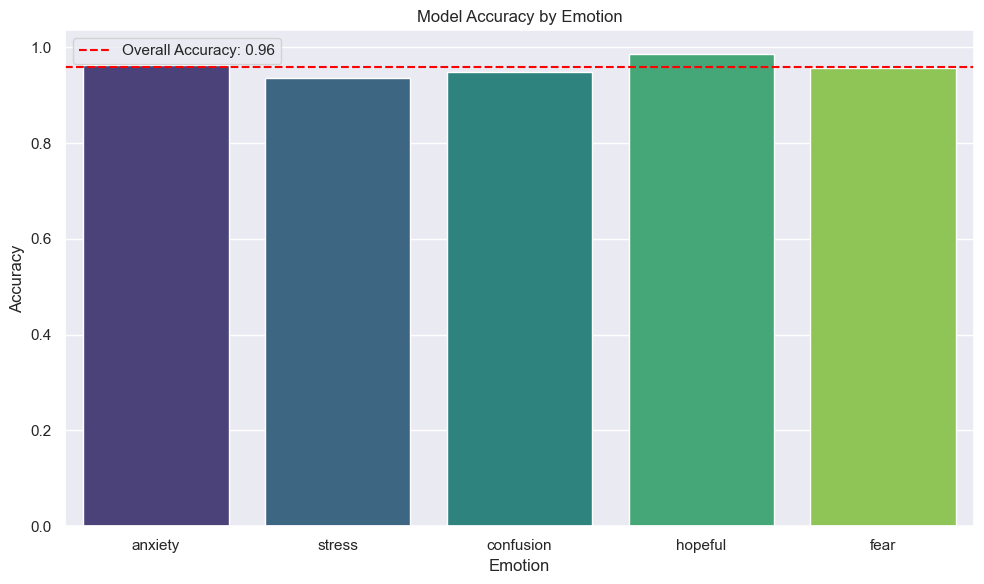

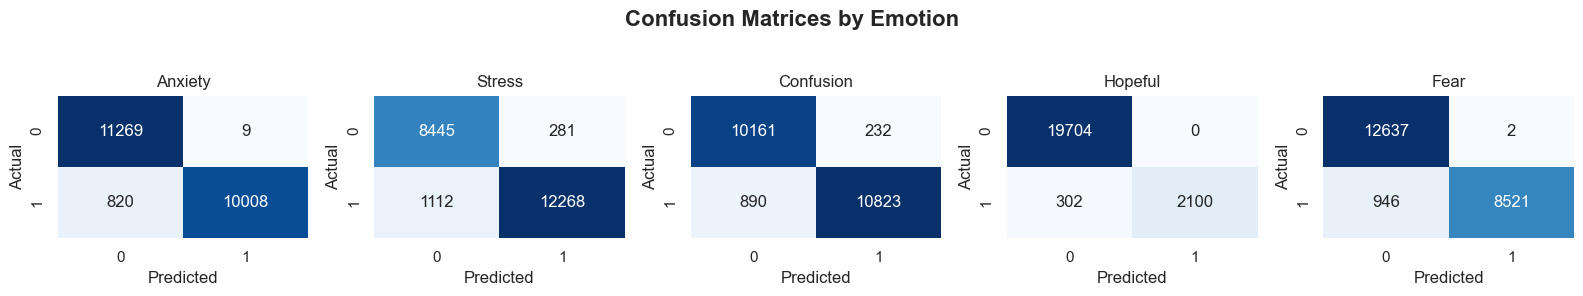

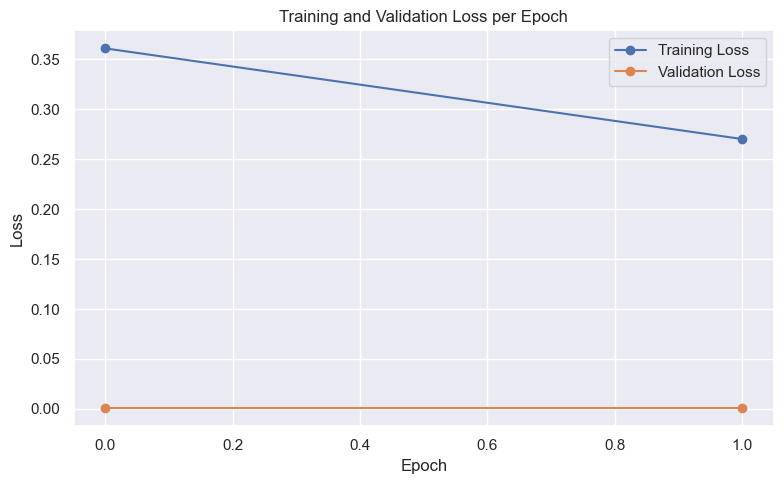

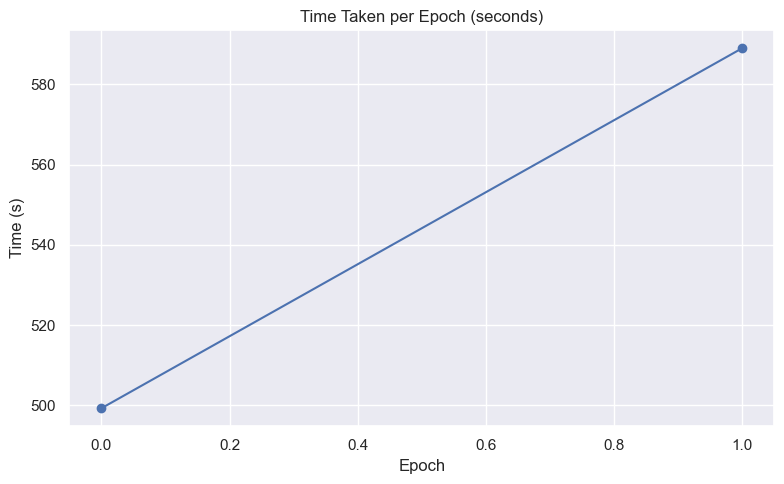


--- Results for Hyperparameter Configuration 2 ---
Model Accuracy by Emotion:
  anxiety: 0.9628
  stress: 0.9497
  confusion: 0.9523
  hopeful: 0.9874
  fear: 0.9617

Overall Accuracy: 0.9628

Classification Reports:


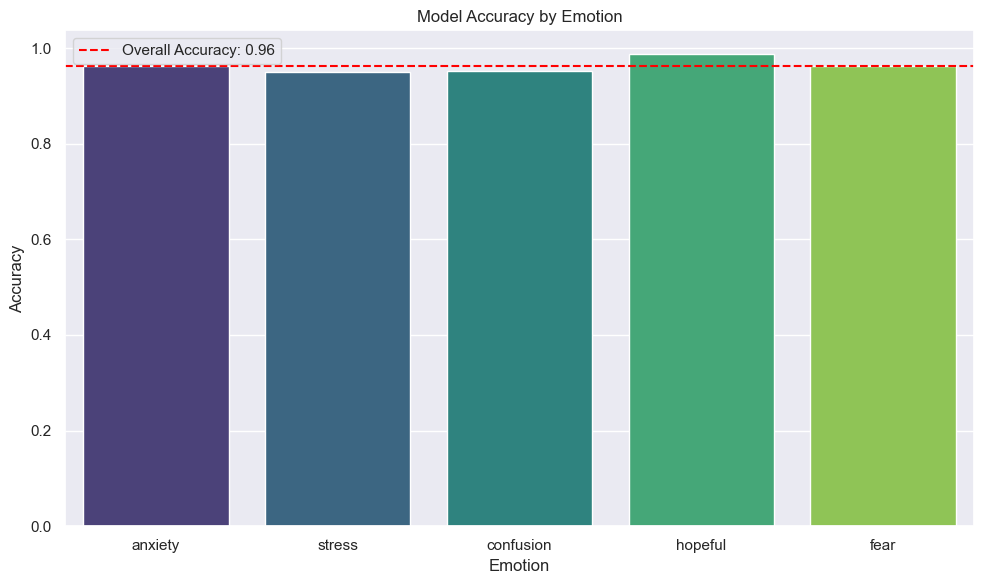

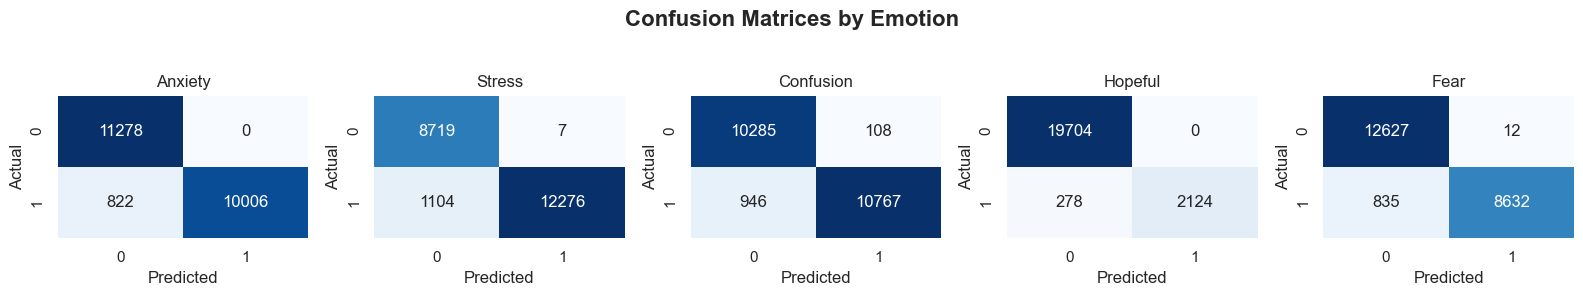

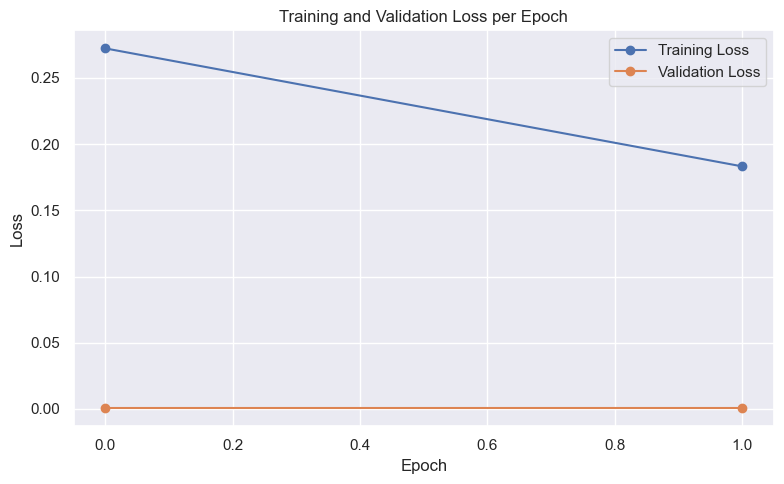

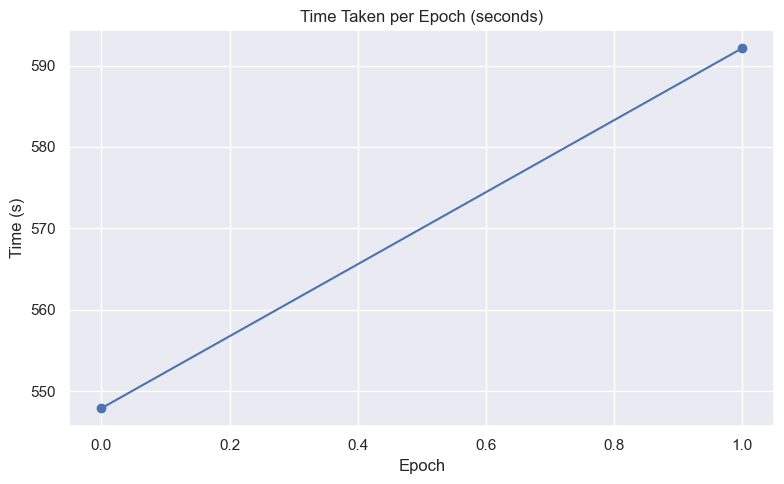

In [16]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Prepare data splits for hyperparameter tuning
    X = df['PatientSentiment'].values
    y = df[EMOTION_STATES].values

    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=NLP_CONFIG['epochs'])
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=NLP_CONFIG['epochs'])

    # Run hyperparameter tuning using the class method
    results = SentimentAnalysisModel.run_hyperparameter_tuning(
        X_train, y_train, X_val, y_val, X_test, y_test,
        emotional_states=EMOTION_STATES,
        device=NLP_CONFIG['device'],
        tokenizer=sa_model.tokenizer,
        max_seq_length=NLP_CONFIG['max_length']
    )

    # Print and plot metrics for each configuration
    for i, res in enumerate(results):
        print(f"\n--- Results for Hyperparameter Configuration {i+1} ---")
        # Compute metrics for each configuration
        emotion_accuracies = {emo: accuracy_score(res['actual_labels'][:, idx], res['predictions'][:, idx]) for idx, emo in enumerate(EMOTION_STATES)}
        sentiment_analysis_metrics = {
            'emotion_accuracies': emotion_accuracies,
            'overall_accuracy': res['accuracy'],
            'classification_reports': {}  # Optionally fill with classification_report if needed
        }
        plotter.print_sentiment_metrics(sentiment_analysis_metrics)
        plotter.plot_accuracy_by_emotion(sentiment_analysis_metrics)
        plotter.plot_confusion_matrices(res['actual_labels'], res['predictions'], EMOTION_STATES)
        plotter.plot_training_validation_loss(res['train_losses'], res['val_losses'])
        plotter.plot_epoch_times(res['epoch_times'])



Best model configuration (balanced for both accuracy and speed):
Learning Rate: 5e-05
Batch Size: 16
Epochs: 2
Accuracy: 0.9584
Training Time: 1088.28 seconds
Combined Score: 0.9709


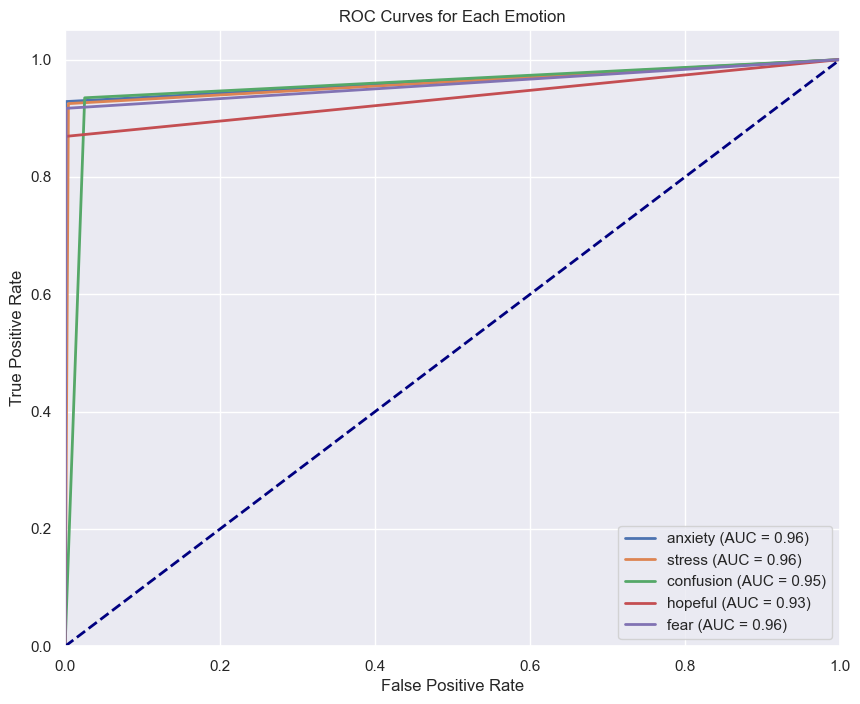

In [17]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Select the best model based on accuracy and training time using the class method
    best_model, best_params, best_idx, combined_scores = SentimentAnalysisModel.get_best_model_from_results(results)

    print(f"\nBest model configuration (balanced for both accuracy and speed):")
    print(f"Learning Rate: {best_params['learning_rate']}")
    print(f"Batch Size: {best_params['batch_size']}")
    print(f"Epochs: {best_params['epochs']}")
    print(f"Accuracy: {results[best_idx]['accuracy']:.4f}")
    print(f"Training Time: {results[best_idx].get('training_time', sum(results[best_idx]['epoch_times'])):.2f} seconds")
    print(f"Combined Score: {combined_scores[best_idx]:.4f}")

    # Plot ROC and AUC for each emotion using the class-based plotter
    plotter.plot_roc_auc_by_emotion(actual_labels, predictions, EMOTION_STATES)


# Run Sentiment Model Unit Tests

Validate the sentiment model's predictions on example texts using the provided unit test. This ensures the model is working as expected and all expected emotions are being detected.

In [18]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Export the best model and tokenizer after hyperparameter tuning
    SentimentAnalysisModel.export_best_model(
        best_model,
        sa_model.tokenizer,
        SENTIMENT_MODEL_EXPORT_PATH_RAW
    )

Best model and tokenizer exported to: d:\Personal\AI-Admissions\Semester 3\AAI-510 - Machine learning Fundamentals and Applications\Final Team Project\aai510_3proj\models\nlp\sentiment_analysis_raw


In [19]:
if is_step_enabled('nlp_sentiment_analysis'):
    example_text = "Patient (minor) is anxious and fearful about medical procedures, sometimes confused by instructions, and stressed by separation from family."
    expected = {'anxiety': True, 'stress': True, 'confusion': True, 'hopeful': False, 'fear': True}

    raw_pred = SentimentAnalysisModel.predict_emotions_raw(
        example_text,
        sa_model.model,
        sa_model.tokenizer,
        NLP_CONFIG['device']
    )

    print("Example text:")
    print(example_text)
    print("\nEmotion prediction comparison:")
    for emo in expected:
        result = "✅" if raw_pred[emo] == expected[emo] else "❌"
        print(f"{emo}: expected={expected[emo]}, predicted={raw_pred[emo]} {result}")

Example text:
Patient (minor) is anxious and fearful about medical procedures, sometimes confused by instructions, and stressed by separation from family.

Emotion prediction comparison:
anxiety: expected=True, predicted=False ❌
stress: expected=True, predicted=False ❌
confusion: expected=True, predicted=False ❌
hopeful: expected=False, predicted=False ✅
fear: expected=True, predicted=False ❌


In [20]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Run the raw model test
    !pytest -s ../tests/test_sentiment_anlaysis.py -k test_sentiment_model_predictions_raw --maxfail=1 --disable-warnings -q


--- Running test_sentiment_model_predictions_raw ---
❌ Test FAILED for: Patient is hopeful and shows no significant anxiety, stress, or fear related to health conditions.
Prediction: {'anxiety': 1, 'stress': 1, 'confusion': 0, 'hopeful': 0, 'fear': 1}
Expected: ['hopeful']

F
================================== FAILURES ===================================
____________________ test_sentiment_model_predictions_raw _____________________

    def test_sentiment_model_predictions_raw():
        print("\n--- Running test_sentiment_model_predictions_raw ---")
        model, tokenizer, _ = _load_model_and_tokenizer(SENTIMENT_MODEL_EXPORT_PATH_RAW)
        model.model.eval()
        results = []
        for text in TEST_TEXTS:
            encoding = tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=NLP_CONFIG['max_length'],
                return_token_type_ids=False,
                padding='max_length',
                truncation=

# Post-Processing with EmotionPostProcessor and Model Evaluation

Use the EmotionPostProcessor and the new SentimentAnalysisModel static methods to predict and evaluate emotions with post-processing.

In [25]:
if is_step_enabled('nlp_sentiment_analysis'):
    example_text = "Patient (minor) is anxious and fearful about medical procedures, sometimes confused by instructions, and stressed by separation from family."
    expected = {'anxiety': True, 'stress': True, 'confusion': True, 'hopeful': False, 'fear': True}

    post_processed = SentimentAnalysisModel.predict_emotions(
        example_text,
        sa_model.model,
        sa_model.tokenizer,
        NLP_CONFIG['device'],
        emotion_variations_path=EMOTION_VARIATIONS_PATH,
        negation_patterns_path=NEGATION_PATTERNS_PATH
    )
    print("Post-processed emotion prediction:", post_processed)
    print("Example text:")
    print(example_text)
    print("\nEmotion prediction comparison:")
    for emo in expected:
        result = "✅" if post_processed[emo] == expected[emo] else "❌"
        print(f"{emo}: expected={expected[emo]}, predicted={post_processed[emo]} {result}")

Post-processed emotion prediction: {'anxiety': True, 'stress': True, 'confusion': True, 'hopeful': False, 'fear': True}
Example text:
Patient (minor) is anxious and fearful about medical procedures, sometimes confused by instructions, and stressed by separation from family.

Emotion prediction comparison:
anxiety: expected=True, predicted=True ✅
stress: expected=True, predicted=True ✅
confusion: expected=True, predicted=True ✅
hopeful: expected=False, predicted=False ✅
fear: expected=True, predicted=True ✅


In [26]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Evaluate the model with post-processing on the test set
    results_post = SentimentAnalysisModel.evaluate_model_with_post_processing(
        sa_model.model,
        sa_model.test_loader,
        sa_model.tokenizer,
        NLP_CONFIG['device'],
        emotion_variations_path=EMOTION_VARIATIONS_PATH,
        negation_patterns_path=NEGATION_PATTERNS_PATH
    )
    print("\nPost-processing overall accuracy:", results_post['accuracy'])
    print("Emotion-wise accuracies:", results_post['emotion_accuracies'])

Evaluating with Post-Processing: 100%|██████████| 691/691 [04:52<00:00,  2.36it/s]


Post-processing overall accuracy: 0.6698000542839049
Emotion-wise accuracies: {'anxiety': 0.6092463584547182, 'stress': 0.6616303266081607, 'confusion': 0.9233692210259657, 'hopeful': 0.46001085678096443, 'fear': 0.694743508549715}


# Rerun Unit Tests for Sentiment Model

After post-processing and evaluation, rerun the unit tests to ensure everything is working as expected.

In [27]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Export the optimized model and tokenizer with post-processor config
    os.makedirs(SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, exist_ok=True)
    shutil.copy(EMOTION_VARIATIONS_PATH, os.path.join(SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, os.path.basename(EMOTION_VARIATIONS_PATH)))
    shutil.copy(NEGATION_PATTERNS_PATH, os.path.join(SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED, os.path.basename(NEGATION_PATTERNS_PATH)))
    SentimentAnalysisModel.export_best_model(
        best_model,
        sa_model.tokenizer,
        SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED
    )
    print(f"Optimized model and post-processor config exported to: {SENTIMENT_MODEL_EXPORT_PATH_OPTIMIZED}")

Best model and tokenizer exported to: d:\Personal\AI-Admissions\Semester 3\AAI-510 - Machine learning Fundamentals and Applications\Final Team Project\aai510_3proj\models\nlp\sentiment_analysis_optimized
Optimized model and post-processor config exported to: d:\Personal\AI-Admissions\Semester 3\AAI-510 - Machine learning Fundamentals and Applications\Final Team Project\aai510_3proj\models\nlp\sentiment_analysis_optimized


In [28]:
if is_step_enabled('nlp_sentiment_analysis'):
    # Run the optimized model test
    !pytest -s ../tests/test_sentiment_anlaysis.py -k test_sentiment_model_predictions_optimized  --maxfail=1 --disable-warnings -q


--- Running test_sentiment_model_predictions_optimized ---
✅ Test PASSED for: Patient is hopeful and shows no significant anxiety, stress, or fear related to health conditions.
Prediction: {'anxiety': 0, 'stress': 0, 'confusion': 0, 'hopeful': 1, 'fear': 0}
Expected: ['hopeful']

✅ Test PASSED for: Patient expresses fear and anxiety about high blood pressure and possible complications.
Prediction: {'anxiety': 1, 'stress': 0, 'confusion': 1, 'hopeful': 0, 'fear': 1}
Expected: ['fear', 'anxiety']

✅ Test PASSED for: Elderly patient expresses fear of declining health, confusion about medications, and stress related to mobility issues.
Prediction: {'anxiety': 1, 'stress': 1, 'confusion': 1, 'hopeful': 0, 'fear': 1}
Expected: ['fear', 'confusion', 'stress']

✅ Test PASSED for: Patient (minor) is anxious and fearful about medical procedures, sometimes confused by instructions, and stressed by separation from family.
Prediction: {'anxiety': 1, 'stress': 1, 'confusion': 1, 'hopeful': 0, 'fear